# 概要

本ファイルでは、データセット(3d_labels)のカメラ画像(CAM_FRONT)に対してセグメンテーションを実施し、Lidarの点群データと結合した拡張点群を生成します。

手順は、次の通りです。

1. セマンティックセグメンテーション  
  カメラ画像に対してセマンティックセグメンテーションを行い、各ピクセルのクラススコアを取得  
　入力：画像  (H, W, 3)  
　出力：セグメンテーションスコア  (H, W, C)


2. 融合 (点群のペインティング)  
  算出したセグメンテーション結果をLidarの点群データに結合し、拡張点群データを作成  
　入力：class_scores, 点群データ(bin)  (x,y,z,intensity)  
　出力：拡張点群データ(bin)  (x, y, z, intensity, C1, C2, C3)


3. 可視化
  - セグメンテーション結果を画像にオーバーラップして表示
  - 点群とセグメンテーション結果を結合した拡張点群を3D散布図に表示

## Output

本ファイルを実行することで、`data/3d_labels_painted`ディレクトリを生成し、拡張点群データ(bin)を保存します。

```
└ data
    ├ 3d_labels
    └ 3d_labels_painted  <-- 本ファイルにて生成されます
        ├ maps
        ├ samples
            ├ CAM_FRONT
            └ LIDAR_TOP  <-- 拡張点群データが格納されます
        └ v1.0-trainval
```

# 準備
## ライブラリのインポート

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

%matplotlib inline

import cv2
import torch
from nuscenes.nuscenes import NuScenes

from utils.pointcloud_seg import (get_segmentation_score,
                                  map_pointcloud_to_image, overlap_seg)
from utils.vis_pointcloud import get_figure_data, view_pointcloud

# インスタンス単体でのペインティング処理
ペインティング処理の動作を確認するため、インスタンス単体での推論を行います。

## 読み込みファイルのパス設定

In [2]:
dataset_path = "../data/3d_labels"

# シーンIDとフレームIDの選択
scene_id = 29
frame_id = 73

## datasetの読み込み

In [3]:
nusc = NuScenes(version='v1.0-trainval', dataroot=dataset_path, verbose=True)

assert scene_id < len(nusc.scene), \
     f"SceneIDの指定値:{scene_id}が総シーン数:{len(nusc.scene)}を超えています。"

target_scene = nusc.scene[scene_id]
print(f"SceneID: {scene_id}")
print(f"  総フレーム数: {target_scene['nbr_samples']}")
print(f"FrameID: {frame_id}")

assert frame_id < target_scene["nbr_samples"], \
     f"FrameIDの指定値:{frame_id}がフレーム数:{target_scene['nbr_samples']}を超えています。"

sample_token = target_scene['first_sample_token']

for i in range(frame_id):
    sample = nusc.get('sample', sample_token)
    sample_token = sample['next']

sample_record = nusc.get('sample', sample_token)

test_key = f"{target_scene['name']}_{frame_id:0>2}"
print(f"test_key: {test_key}")

Loading NuScenes tables for version v1.0-trainval...
20 category,
8 attribute,
4 visibility,
2176 instance,
2 sensor,
74 calibrated_sensor,
2475 ego_pose,
37 log,
37 scene,
2475 sample,
4950 sample_data,
42142 sample_annotation,
37 map,
Done loading in 1.006 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.
SceneID: 29
  総フレーム数: 183
FrameID: 73
test_key: scene-0109_73


In [4]:
# LidarとCamのtokenを取得
pointsensor_token = sample_record['data']['LIDAR_TOP']
camera_token = sample_record['data']['CAM_FRONT']
# LidarとCamのレコードを取得
pointsensor = nusc.get('sample_data', pointsensor_token)
cam = nusc.get('sample_data', camera_token)

# inputデータの形式で各メタ情報を取得
cam_path = os.path.join(nusc.dataroot, cam['filename'])
lidar_path = os.path.join(nusc.dataroot, pointsensor['filename'])
cam_ego_pose = nusc.get('ego_pose', cam['ego_pose_token'])
cam_calibration = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
lidar_ego_pose = nusc.get('ego_pose', pointsensor['ego_pose_token'])
lidar_calibration = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])

# 1. セグメンテーション

第1ステップでは、カメラ画像に対して、セマンティックセグメンテーションを実行し、ピクセルごとのセグメンテーションスコアを取得します。

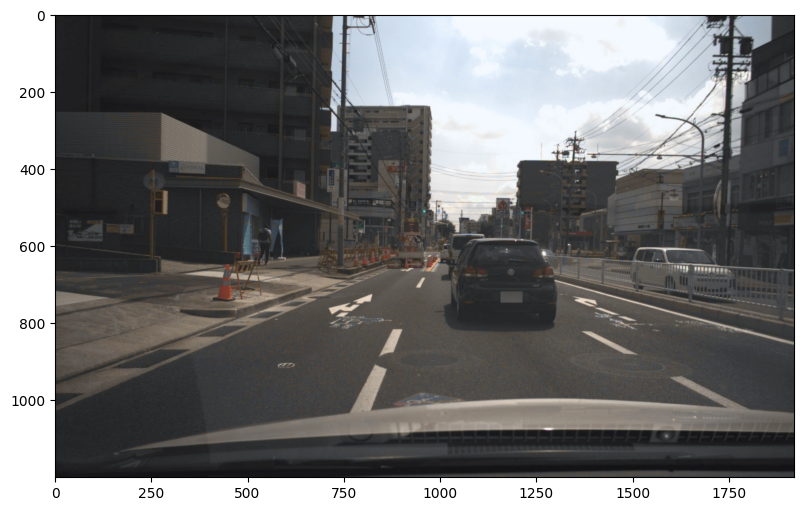

In [5]:
# 入力画像の確認
img = Image.open(cam_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)

## セグメンテーションモデルの定義

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 学習済みのdeeplabv3モデルをロード
model_seg = torch.hub.load('pytorch/vision:v0.6.0',
                           'deeplabv3_resnet101', pretrained=True)
model_seg.eval()
model_seg.to(device)

print("Segmentation Model Loaded.")

Using cuda device


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Segmentation Model Loaded.


## セグメンテーションモデルの推論

今回のモデルの推論で出力されるスコアは、次の3クラスです。

1. background
2. car
3. person

In [7]:
class_scores = get_segmentation_score(cam_path, model_seg, device)

print("class_scores shape: ", class_scores.shape)  # (H, W, C)

class_scores shape:  (1200, 1920, 3)


# 2. 融合 (点群のペインティング) 

セグメンテーションスコアを点群に投影し、点群の次元にセグメンテーションスコアを追加することで拡張点群を取得します。  
点群の次元は (x, y, z, r) から (x, y, z, r, C1, C2, C3) へ拡張されます。

In [8]:
# Lidar点群を画像に投影して画像座標を取得
points_mask, points_image = map_pointcloud_to_image(cam_path,
                                                    lidar_path,
                                                    cam_ego_pose,
                                                    lidar_ego_pose,
                                                    cam_calibration,
                                                    lidar_calibration)

print("points_mask", points_mask.shape)   # 画像範囲でマスクした点群 (N, pcd_dim)
print("points_image", points_image.shape)  # (N, 2)  2:カメラ画像のx,y軸

points_mask (39581, 4)
points_image (39581, 2)


In [9]:
# 点群データとセグメンテーションを結合し、拡張点群データを作成
class_num = class_scores.shape[2]

# points_image は x,y が画像座標で、cols, rows であるのに対し、
# class_score は (rows, cols) なので、以下のインデックスの値は 1 → 0 と逆になる
point_scores = class_scores[points_image[:, 1], points_image[:, 0]]
point_scores = point_scores.reshape(-1, class_num)

print(point_scores.shape)  # (N, class_num)

(39581, 3)


In [10]:
painted_lidar = np.hstack([points_mask, point_scores])
painted_lidar = painted_lidar.astype(np.float32)

print(painted_lidar.shape)  # (N, pcd_dim + class_num)

(39581, 7)


## 可視化

### セグメンテーション + 画像

セグメンテーション結果を画像にオーバーラップして表示します。

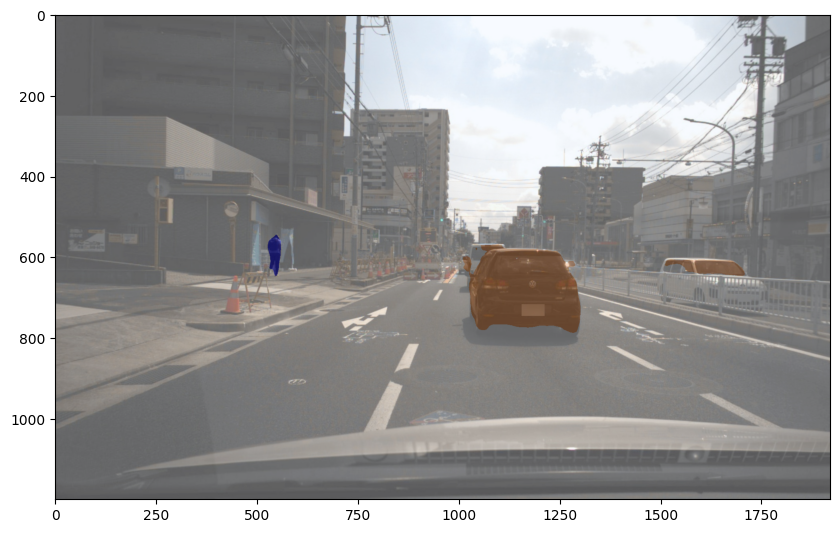

In [11]:
img = Image.open(cam_path)
img_np = np.array(img)

img_seg = overlap_seg(img_np,
                      class_scores,
                      opacity=0.3)

plt.figure(figsize=(10, 8))
plt.imshow(img_seg)

### セグメンテーション + 点群

点群とセグメンテーション結果を結合した拡張点群を3D散布図に表示します。

In [12]:
pc_data = painted_lidar[::4]  # 可視化処理の軽減のため1/4にデータ間引き

# 拡張点群のセグメンテーションの色
segcolor_dict = {0: "darkgray",  # background
                 1: "orange",    # car
                 2: "blue"}      # person

points_xyz = pc_data[:, :3]  # (x, y, z)を抽出
points_class = np.argmax(pc_data[:, 4:], axis=1)  # Classを抽出
points_colors = [segcolor_dict[i] for i in points_class]

fig = view_pointcloud(points_xyz, points_colors, mode="front")
fig.show()

# 全点群データに対してペインティング処理

拡張点群データ(bin)を生成し、`3d_labels_painted`ディレクトリに保存します。

In [13]:
# 保存先ディレクトリの設定
save_dir = "../data/3d_labels_painted"

In [14]:
# 保存先ディレクトリの作成
Path(save_dir).mkdir(exist_ok=True)
(Path(save_dir) / "samples").mkdir(exist_ok=True)
(Path(save_dir) / "samples/LIDAR_TOP").mkdir(exist_ok=True)

In [15]:
# Lidarデータ以外の3d_labelsファイルを保存先ディレクトリにコピー
!cp -r {str(Path(dataset_path) / "maps")} {str(Path(save_dir))} 
!cp -r {str(Path(dataset_path) / "samples/CAM_FRONT")} {str(Path(save_dir) / "samples/CAM_FRONT")} 
!cp -r {str(Path(dataset_path) / "v1.0-trainval")} {str(Path(save_dir) / "v1.0-trainval")} 

全サンプルに対して、拡張点群データを生成し`3d_labels_painted/samples/LIDAR_TOP`に保存します。

In [16]:
for sample_record in tqdm(nusc.sample):

    # LidarとCamのtokenを取得
    pointsensor_token = sample_record['data']['LIDAR_TOP']
    camera_token = sample_record['data']['CAM_FRONT']
    # LidarとCamのレコードを取得
    pointsensor = nusc.get('sample_data', pointsensor_token)
    cam = nusc.get('sample_data', camera_token)

    # inputデータの各メタ情報を取得
    cam_path = os.path.join(nusc.dataroot, cam['filename'])
    lidar_path = os.path.join(nusc.dataroot, pointsensor['filename'])
    cam_ego_pose = nusc.get('ego_pose',
                            cam['ego_pose_token'])
    cam_calibration = nusc.get('calibrated_sensor',
                               cam['calibrated_sensor_token'])
    lidar_ego_pose = nusc.get('ego_pose',
                              pointsensor['ego_pose_token'])
    lidar_calibration = nusc.get('calibrated_sensor',
                                 pointsensor['calibrated_sensor_token'])

    # セグメンテーションモデルの推論
    class_scores = get_segmentation_score(cam_path, model_seg, device)

    # Lidar点群を画像に投影して画像座標を取得
    points_mask, points_image = map_pointcloud_to_image(cam_path,
                                                        lidar_path,
                                                        cam_ego_pose,
                                                        lidar_ego_pose,
                                                        cam_calibration,
                                                        lidar_calibration)

    # 点群データとセグメンテーションを結合し、拡張点群データを作成
    class_num = class_scores.shape[2]
    point_scores = class_scores[points_image[:, 1], points_image[:, 0]]
    point_scores = point_scores.reshape(-1, class_num)

    painted_lidar = np.hstack([points_mask, point_scores])
    painted_lidar = painted_lidar.astype(np.float32)

    # 拡張点群データbinを保存
    save_name = Path(save_dir) / "samples/LIDAR_TOP" / Path(lidar_path).name
    painted_lidar.tofile(save_name)

  0%|          | 0/2475 [00:00<?, ?it/s]

以上